###  Created by Luis Alejandro (alejand@umich.edu)

Simple exploration of extraction techniques and some brief comparison

**Install the following packages:**

pip install npTDMS<br>
pip install mysql-connector-python<br>
pip install librosa

In [1]:
import mysql.connector
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate
from scipy.signal import spectrogram
import librosa

In [2]:
def preprocess(data,fs,factor=6):
    data = decimate(data,factor)
    fs = int(fs/factor)
    return data,fs

def extract_mfcc(data,fs):
    data,fs = preprocess(data,fs)
    mat = librosa.feature.mfcc(np.asfortranarray(data),fs,n_mfcc=30,hop_length=512,fmax=4000)
    return mat

def extract_spec(data,fs):
    data,fs = preprocess(data,fs)
    f, t, Sxx = spectrogram(data,fs,mode='magnitude',
                                window='hamming',nperseg=512,noverlap=256)
    return f,t,Sxx

In [3]:
# Connect to DB
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    passwd = "cuba",
    database = "airnoise"
)
print(mydb)

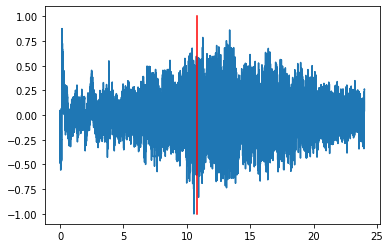

In [4]:
dbcursor = mydb.cursor()
fs = 51200
measurement = 3
array = 1
microphone = 4
sql = '''SELECT m.url, t.location FROM tmid t, measurements m WHERE t.measurement = {} AND
    t.array = {} AND t.microphone = {} AND m.id_measurement = t.measurement'''.format(
    measurement,array,microphone)
dbcursor.execute(sql)
result = dbcursor.fetchall()
url = result[0][0]
tmid = result[0][1]
tdms = TdmsFile("../../datasets/classification/noise/" + url)
data = tdms.channel_data(group = 'Untitled', channel = 'cDAQ1Mod' + str(array) + '/ai' + str(microphone - 1))
data = data / np.absolute(data).max()
time = np.arange(len(data)) / fs
plt.plot(time, data)
plt.plot([tmid,tmid],[-1,1],'r-')

(30, 34)
-39.652905
128.06111
5.703791
(257, 65)


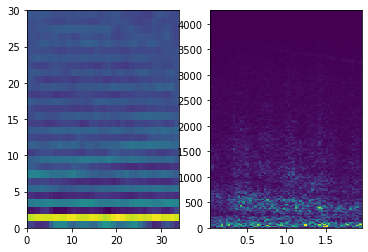

In [5]:
offset = 0
expand = 1
start = int((tmid+offset-expand)*fs)
end = int((tmid+offset+expand)*fs)
segment = data[start:end+1]
mat = extract_mfcc(segment,fs)
print(mat.shape)
print(mat.min())
print(mat.max())
print(mat.mean())
mat = mat/np.absolute(mat).max()
plt.subplot(121)
plt.pcolormesh(mat, cmap='viridis')
f,t,Sxx = extract_spec(segment,fs)
print(Sxx.shape)
plt.subplot(122)
plt.pcolormesh(t,f,Sxx,cmap='viridis')

(30, 34)
-73.49833
96.18359
4.6033297
(257, 65)


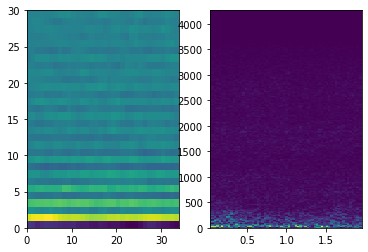

In [6]:
offset = 10
expand = 1
start = int((tmid+offset-expand)*fs)
end = int((tmid+offset+expand)*fs)
segment = data[start:end+1]
mat = extract_mfcc(segment,fs)
print(mat.shape)
print(mat.min())
print(mat.max())
print(mat.mean())
mat = mat/np.absolute(mat).max()
plt.subplot(121)
plt.pcolormesh(mat, cmap='viridis')
f,t,Sxx = extract_spec(segment,fs)
print(Sxx.shape)
plt.subplot(122)
plt.pcolormesh(t,f,Sxx,cmap='viridis')